Given two measures $f^+$ and $f^-$ with equal mass, the [Monge-Kantorovich Equations](https://www.intlpress.com/site/pub/files/_fulltext/journals/cdm/1997/1997/0001/CDM-1997-1997-0001-a002.pdf) reads as finding the Kantorovich Potential $u^*$ and
the Optimal Transport Densisity $\mu^*$ solving the following system of PDE
$$
\nabla \cdot ( \mu^*(x) \nabla u^*(x) )= f^{+}(x)-f^{-}(x) \\
|\nabla u^*(x)|\leq 1 \\
|\nabla u^*(x)|=1 \mbox{\ where \ } \mu^*(x)>0. \\
$$
This is the PDE-based formulation of the Optimal Transport Problem with cost equal to the Euclidean distance.

In this notebook we reproduce Test-Case-1
[FaccaDaneriCardinPutti2020](https://link.springer.com/article/10.1007/s10915-020-01170-8).
where the problem is settled in the square $[0,1]\times[0,1]\subset R^2$ with $f^+$ and $f^-$
given by
$$
f^+(x)=2 \ \mbox{on}\  [1/8,3/8]\times [1/4,3/4] \\
f^-(x)=2 \ \mbox{on}\  [5/8,7/8]\times [1/4,3/4] \\
$$
and zero elsewhere.

We show how to pass the input data (triangulationed grid, forcings terms) and the algorithm controls to the dmk solver. Copy this notebook, change the triangulation and the measures $f^+$ and $f^-$ to run your own experiments.

In [1]:
# 
# Loading stardard and dmk pyhton modules
#

# Standard tools
import sys
import numpy as np
import os
current_source_dir=os.getcwd()

# Import I/O for timedata
try:
    sys.path.append('../../../../../globals/python/timedata/')
    import timedata as td
except:
    print("Global repo non found")

# Import geometry tools
sys.path.append('../../../../../geometry/python/')
import meshtools as mt
sys.path.append('../../../preprocess/assembly/')
import example_grid

# Import dmk tools
sys.path.append('../../')
import dmk_p1p0 


relative_libpath='../../../../build/python/fortran_python_interface/'
dmk_lib_path=os.path.abspath(os.path.normpath(current_source_dir+'/'+relative_libpath))
sys.path.append(dmk_lib_path)
from dmk import (Dmkcontrols,  # controls for dmk simulations)
                 Timefunctionals, # information of time/algorithm evolution
                 Dmkp1P0Discretization,
                 dmkp1p0_steady_data,
                 Tdenspotentialsystem,
                 Dmkinputsdata,
                 Abstractgeometry,
                 write_parent,
                )

relative_libpath='../../../../otp_solver/python/'
dmk_lib_path=os.path.abspath(os.path.normpath(current_source_dir+'/'+relative_libpath))
sys.path.append(dmk_lib_path)
from dmk_p1p0 import (init_dmk,
                     set_forcing_term,
                      check_inputs,
                     getgeometry)


# Import plot tools
import matplotlib.pyplot as plt

/home/fh/srcs/globals/python/timedata
/home/fh/srcs/dmk_solver/otp_solver/python/examples/federico
/home/fh/srcs/dmk_solver/otp_solver/preprocess/assembly
/home/fh/srcs/globals/python/timedata
/home/fh/srcs/dmk_solver/build/python/fortran_python_interface


In [2]:
# set mesh
nref=0

# set lift
power=6
lift=10**(-power)

# set variable
variable='gfvar'

# set tow level grid
use_subgrid=np.zeros(1,dtype=np.int8)
use_subgrid=1

# label for file
str_power=f"{power:02d}"
str_subgrid=f"sub{use_subgrid:01d}"

print(str_power,str_subgrid)

06 sub1


In [3]:
#
# read mesh
#
dir_path='runs/rect_cnst_nref'+str(nref)+'/'
file_path=dir_path+'grid.dat'
[coord,topol,flags]=mt.read_grid(file_path)

In [4]:
#
# We create piecewise constant rapresentations of $f,f^+,f-$ and $\mu^*$,
# evaluating the function on cell centroids.
#

# define source and sink functions, value of grid centroids
def source(coord):
    x=coord[0]; y=coord[1]
    if (x<1.0/2.0):
        fvalue=0.0
        if ((x >= 1.0/8.0) and (x<=3.0/8.0) and
            (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
            fvalue=2.0
    else:
        fvalue=0.0
        
    return fvalue;

def sink(coord):
    x=coord[0]; y=coord[1] 
    if (x>=1.0/2.0):
        fvalue=0.0
        if ((x >= 5.0/8.0) and (x<=7.0/8.0) and
            (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
            fvalue=2.0
    else:
        fvalue=0.0       
    return fvalue;
# For this case there exists an explicit solution of the Monge-Kantorivich equations:
# The optimal transport density:
def optimal_transport_density(coord):
    x=coord[0]; y=coord[1];
    if (x<1.0/2.0):
        fvalue=0.1
        if ((x >= 1.0/8.0) and (x<=3.0/8.0) and
            (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
            fvalue=(x-1.0/8.0)*2.0
        elif ((x >= 3.0/8.0) and (x<=5.0/8.0) and
              (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
            fvalue=(3.0/8.0-1.0/8.0)*2.0 
        elif ((x >= 5.0/8.0) and (x<=7.0/8.0) and
              (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
            fvalue=(7.0/8.0-x)*2.0
    else:
        fvalue=0.0
    return fvalue;
# exact wasserstein distance
exact_wass1=1.0/8.0


# and the Kantorovich potential
def kantorovich_potenial(coord):
    x=coord[0];        
    return -x;

# compute functions on cell centroids
ncell=len(topol)
bar_cell=mt.make_bar(coord,topol).transpose()
size_cell=mt.make_size(coord,topol);
source_cell=np.zeros([ncell]); sink_cell=np.zeros([ncell]); opttdens_cell=np.zeros([ncell])
for i in range(ncell):
    source_cell[i] = source(bar_cell[:,i])
    sink_cell[i]   = sink(bar_cell[:,i])
    opttdens_cell[i] = optimal_transport_density(bar_cell[:,i])
forcing_cell=source_cell-sink_cell#*(np.dot(size_cell,source_cell)/np.dot(size_cell,sink_cell))

print(np.dot(size_cell,forcing_cell))

td.write_steady_timedata(dir_path+'forcing.dat',forcing_cell)

0.0


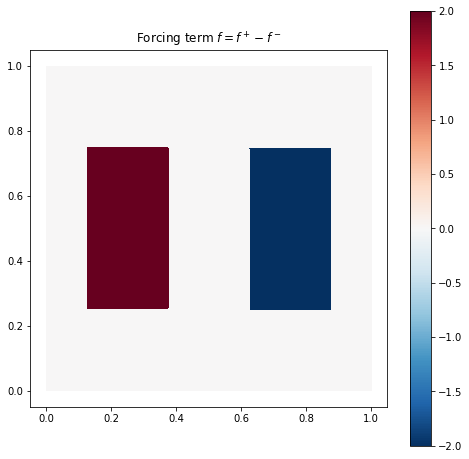

In [5]:
import matplotlib.tri as mtri
#
# plot forcing term
#
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, forcing_cell , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Forcing term $f=f^+-f^-$')
plt.show()


We load the controls from file. You can either change it in the file or change some controls in the next cell.

In [6]:
# init controls
ctrl = dmk_p1p0.init_dmkctrl(tdens_gfvar=variable,
                             explicit_implicit='implicit')

# set flag grids
ctrl.id_subgrid=use_subgrid
print(ctrl.time_discretization_scheme)

# The user can change any controls inside the ctrl type.
# Here we set the saving frequency (save all) and the convergence tolerance
ctrl.id_save_dat=3
ctrl.fn_tdens=dir_path+'tdens'+str_power+str_subgrid+'.dat'

ctrl.fn_pot=dir_path+'pot'+str_power+str_subgrid+'.dat'
ctrl.fn_statistics=dir_path+'dmk'+str_power+str_subgrid+'.log'


#ctrl.max_time_iterations=3
ctrl.tolerance_system_variation=1e-10
ctrl.tolerance_nonlinear=1e-13

# uncomment and try also this setting
ctrl.outer_solver_approach='ITERATIVE' 
ctrl.outer_solver_approach='AGMG' # also AGMG if available
#ctrl.outer_krylov_scheme='PCG'
ctrl.outer_tolerance=1e-7

ctrl.relax_direct=0.0
ctrl.relax4prec=1e-10
ctrl.min_tdens=0

ctrl.max_time_iterations=100
ctrl.deltat=2
ctrl.deltat_control=1
ctrl.deltat_expansion_rate=1.5
ctrl.deltat_lower_bound=1e-2
ctrl.deltat_upper_bound=1e6
ctrl.max_restart=3

#
# print and info
#
ctrl.info_update=2


#
# init type for storing evolution/algorithm info
#
timefun=Timefunctionals.evolfun()
Timefunctionals.evolfun_constructor(timefun, 0,
                                    ctrl.max_time_iterations,
                                    ctrl.max_nonlinear_iterations)

4


In [7]:
# Init. Fortran derivied types: 
# meshes tdens/pot containers, inputs container ans discretization 
[ grid,subgrid,tdpot,dmkin] = init_dmk(topol, coord, ctrl.id_subgrid)

if (use_subgrid==1):
    [topol_subgrid,coord_subgrid]=getgeometry(subgrid)
    mt.write_grid(coord_subgrid.transpose(),topol_subgrid,dir_path+'subgrid.dat')
    write_parent(subgrid,dir_path+'parent.dat')

32 23 3


In [8]:
# Init spatial discretization
p1p0=Dmkp1P0Discretization.dmkp1p0()
print(use_subgrid)
Dmkp1P0Discretization.dmkp1p0_constructor(p1p0,ctrl,use_subgrid,grid,subgrid)

1


In [9]:
# shorthand
ntdens=grid.ncell
npot=subgrid.nnode

# set tdens-pot variable
tdpot.tdens[:]= 1.0
tdpot.pot[:]=0.0
#
# Set inputs
#

# integrate forcing term w.r.t. p1 base function
dmkin =  set_forcing_term(dmkin,subgrid,forcing_cell,np.zeros(npot))
td.write_steady_timedata(dir_path+'rhs'+str_subgrid+'.dat',dmkin.rhs)
# set pflux exponent 
dmkin.pflux = 1
dmkin.lambda_lift=lift
if ( check_inputs(dmkin) != 0):
    info=-1
# set reference solutions if exist
if 'optimal_tdens' in locals():
    Dmkinputsdata.set_optimal_tdens(dmkin,0,optimal_tdens)
if 'optimal_pot' in locals() :
    Dmkinputsdata.set_optimal_pot(dmkin,0,optimal_pot)

In [10]:
# solve with dmk
info=np.zeros(1,dtype=np.int8)
i=np.zeros(1,dtype=np.int8)
dmkp1p0_steady_data(grid, subgrid, ctrl.id_subgrid,tdpot, dmkin, ctrl, info,timefun=timefun)
info=info[0]

# Copy before freeing memory.
# Use np.array() function because you will get errors otherwise
opttdens=np.array(tdpot.tdens).copy()
optpot=np.array(tdpot.pot).copy()

td.write_steady_timedata(dir_path+'opttdens'+str_power+str_subgrid+'.dat',opttdens)
td.write_steady_timedata(dir_path+'optpot'+str_power+str_subgrid+'.dat',optpot)

# free memory
Tdenspotentialsystem.tdpotsys_destructor(tdpot, 0)
Dmkinputsdata.dmkinputs_destructor(dmkin,0)
Abstractgeometry.mesh_destructor(grid, 0)
Abstractgeometry.mesh_destructor(subgrid, 0)

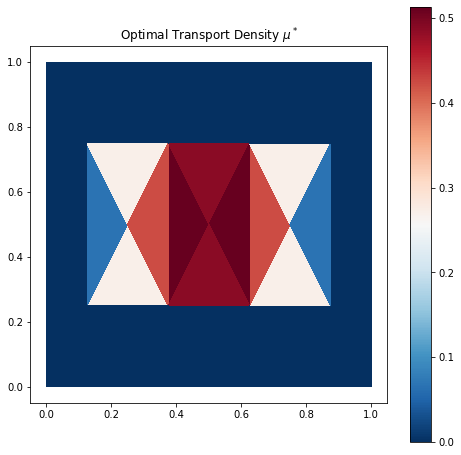

In [11]:
import matplotlib.tri as mtri
# plot forcing term

triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, opttdens , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Optimal Transport Density $\mu^*$')
plt.show()
mt.write_grid(coord_subgrid.transpose(),topol_subgrid,dir_path+'subgrid.dat')


36


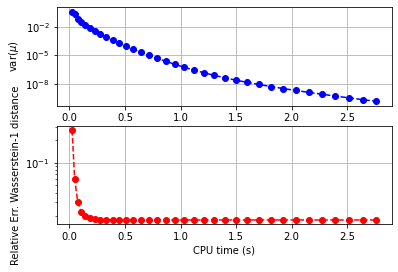

In [12]:
# plot convergence toward steady state
print(timefun.last_time_iteration)
time      = np.array(timefun.time[0:timefun.last_time_iteration]);
cpu_time  = np.array(timefun.cpu_time[0:timefun.last_time_iteration])
var_tdens = np.array(timefun.var_tdens[1:timefun.last_time_iteration])
wass1     = np.array(timefun.lyapunov[1:timefun.last_time_iteration])
errwass1=(wass1[:]-exact_wass1)/(exact_wass1)

plt.figure(1)
plt.subplot(211)
plt.yscale('log')
plt.ylabel('var($\mu$)')
plt.xlabel('CPU time (s)')
plt.grid(True)
plt.plot(cpu_time[1:], var_tdens, 'bo--')

plt.subplot(212)
plt.yscale('log')
plt.ylabel('Relative Err. Wasserstein-1 distance')
plt.xlabel('CPU time (s)')
plt.grid(True)
plt.plot(cpu_time[1:], errwass1, 'ro--')
plt.show()